# Acessing model data using intake-esm

To access the CMIP6 model data and CESM-PPE data we created intake catalogs to help browse and subset the data. The catalogs are stored in shared folder `/mnt/craas1-ns9989k-geo4992/data/intake-catalogs/`

In [1]:
# Importing the required packages
import intake
import xarray as xr
import intake_esm
import numpy as np
import matplotlib.pyplot as plt

## Reading and browsing the catalog

In [2]:
# Open the catalog

# col = intake.open_esm_datastore('https://storage.googleapis.com/cmip6/pangeo-cmip6.json') # Remote Pangeo

col = intake.open_esm_datastore('/mnt/craas1-ns9989k-geo4992/data/cmip6.json') # Local data stored on NIRD
col

,unique
variable_id,583
table_id,24
source_id,75
experiment_id,94
member_id,190
grid_label,11
time_range,9100
activity_id,18
institution_id,35
version,577


Under the hood `intake-esm` uses a large table csv, which contains some metadata and the paths of where to find it. The data can be stored both locally or in a remote cloud storage i.e `pangeo-cloud`. 

```{note}
Since the paths listed in the csv table are absolute, notebook starting from the same catalog can be run from any directory, without needing to change the in side the notebook paths. 
```

 

### Browsing the catalog: Comparing the change in AOD over the historical period across CMIP6 models

The keywords when browsing is columns of the table, e.g. `variable_id`, `source_uid` etc. To list all the keys available for a given key word you can use the `col.unique()['<keyword>']` function. 

In [3]:
col = col.search(
    variable_id='od550aer',
    experiment_id='histSST'
)
col

,unique
variable_id,1
table_id,1
source_id,9
experiment_id,1
member_id,4
grid_label,3
time_range,185
activity_id,2
institution_id,9
version,9


Models available for this request:

In [4]:
col.unique()['source_id']

['CNRM-ESM2-1',
 'MPI-ESM-1-2-HAM',
 'MIROC6',
 'UKESM1-0-LL',
 'MRI-ESM2-0',
 'GISS-E2-1-G',
 'CESM2-WACCM',
 'GFDL-ESM4',
 'EC-Earth3-AerChem']

## Loading the data and plotting

```{warning}
The catalog can be huge, always query and subset catalog before loading the data. Preferably down to level of experiment and variable.
```

The `.to_dataset_dict` function can accept an optional preprocessing function which can be used to harmonize the datasets, temporal resampling, or slicing.
Below we made a preprocessing function for resampling the data into annual means and calculate the global average to allow for easily plotting the time series. 

```{note}
Without a `preprocesses` function `.to_dataset_dict` will just attempt to aggregate all the files along the `time` dimension, for each model or `source_id`. 

```


In [5]:
def resample_calculate_and_global_avg(ds):
    """
    Function to resample the data to annual mean and calculate the global average.
    """
    ds=ds.resample(time='YE').mean() # Resample to annual mean
    ds = ds.drop_vars(['lat_bnds','lon_bnds'], errors='ignore') # create conflict when calculating global average
    weights = np.cos(np.deg2rad(ds.lat)) # Make weighted global average
    ds_weighted = ds.weighted(weights)
    weighted_mean = ds_weighted.mean(dim=['lon','lat'])
    
    return weighted_mean


```{admonition} Using dask
:class: dropdown
The processing can be done in parallel using dask, which can speed things up a bit.  
The dask cluster below is constrained within the resource each user have available.
The corresponding dask cluster panel can be viewed at https://escience2024-test.craas1.sigma2.no/user/<usr-id>/proxy/8787/status
```python
from dask.distributed import Client, LocalCluster
client = Client(LocalCluster(n_workers=4, threads_per_worker=1, memory_limit='16GB'))
```


In [6]:
# dataset_dict = col.to_dataset_dict()
dataset_dict = col.to_dataset_dict(xarray_open_kwargs={'use_cftime':True, 'chunks':{'time':48}}, 
                           aggregate=True,
                           preprocess=resample_calculate_and_global_avg,
                           skip_on_error=True,
                           xarray_combine_by_coords={'combine_attrs': 'override'} 
                          )



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'


/opt/conda/envs/pangeo-notebook/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'od550aer' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/opt/conda/envs/pangeo-notebook/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'od550aer' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


In [12]:
col.to_dataset_dict(xarray_open_kwargs={'use_cftime':True, 'chunks':{'time':48}}, 
                           aggregate=True,
                           skip_on_error=True,
                           xarray_combine_by_coords={'combine_attrs': 'override'} 
                          )


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'


/opt/conda/envs/pangeo-notebook/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'od550aer' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


{'AerChemMIP.CNRM-CERFACS': <xarray.Dataset> Size: 260MB
 Dimensions:      (lat: 128, lon: 256, time: 1980, axis_nbounds: 2, member_id: 1)
 Coordinates:
   * lat          (lat) float64 1kB -88.93 -87.54 -86.14 ... 86.14 87.54 88.93
   * lon          (lon) float64 2kB 0.0 1.406 2.812 4.219 ... 355.8 357.2 358.6
   * time         (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
   * member_id    (member_id) object 8B 'r1i1p1f2'
 Dimensions without coordinates: axis_nbounds
 Data variables:
     time_bounds  (time, axis_nbounds) object 32kB dask.array<chunksize=(48, 2), meta=np.ndarray>
     od550aer     (member_id, time, lat, lon) float32 260MB dask.array<chunksize=(1, 48, 128, 256), meta=np.ndarray>
 Attributes: (12/65)
     Conventions:                      CF-1.7 CMIP-6.2
     creation_date:                    2018-08-08T14:22:32Z
     description:                      Historical transient with SSTs prescrib...
     title:                            CNRM-ESM2-1 model out

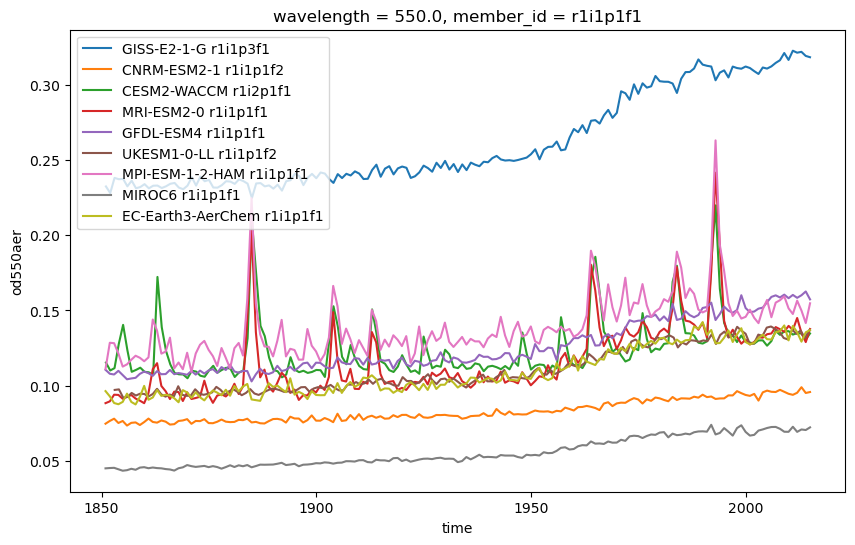

In [7]:
fig,ax = plt.subplots(figsize=(10,6))
for datakey, data in dataset_dict.items(): # Looping over ever varable in the dictionary
    source_id = data.attrs['intake_esm_attrs:source_id']
    member_id = data.attrs['intake_esm_attrs:member_id']
    data['od550aer'].isel(member_id=0).plot(label=f'{source_id} {member_id}', ax=ax)

ax.legend()
    

### Exporting a subset of the catalog

Most likely you will only be analyzing a small subset of experiments the model experiment and it could be beneficial to work with a reduced catalog. 
Below we will make a subset that only contain the information related to `histSST` and `histSST-piaer`, and only the absorption optical depth (`od550abs`) and total optical depth (`od550aer`). 

In [8]:
col = intake.open_esm_datastore('/mnt/craas1-ns9989k-geo4992/data/cmip6.json') # Local data stored on NIRD

In [9]:
col = col.search(    
    experiment_id=['histSST', 'histSST-piaer'],
    variable_id = ['od550abs', 'od550aer']
)
col

,unique
variable_id,1
table_id,1
source_id,9
experiment_id,1
member_id,4
grid_label,3
time_range,185
activity_id,2
institution_id,9
version,9


Then when we are happy with the selection the catalog can be exported as follows:

In [10]:
col.serialize(name='histSST-AerChemMIP',catalog_type='file',directory='~/')

Successfully wrote ESM catalog json file to: file:///home/fc-3auid-3a9fdc0c87-2d7836-2d4bdc-2db802-2d9a250c322e3b//histSST-AerChemMIP.json


In [11]:
col = intake.open_esm_datastore('~/histSST-AerChemMIP.json')
col

,unique
variable_id,1
table_id,1
source_id,9
experiment_id,1
member_id,4
grid_label,3
time_range,185
activity_id,2
institution_id,9
version,9
